## LSTM Classifier

In [136]:
!pip install fasttext

     |████████████████████████████████| 68 kB 3.3 MB/s eta 0:00:011
  Using cached pybind11-2.9.0-py2.py3-none-any.whl (210 kB)
  Created wheel for fasttext: filename=fasttext-0.9.2-cp37-cp37m-linux_x86_64.whl size=3125050 sha256=8fbafd975151eb772ce6556273a996cd07c143c15621295e3f493f3b7a66aaf6
  Stored in directory: /root/.cache/pip/wheels/4e/ca/bf/b020d2be95f7641801a6597a29c8f4f19e38f9c02a345bab9b
Successfully built fasttext


In [137]:
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf 

from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, SpatialDropout1D
from tensorflow.keras.callbacks import EarlyStopping

In [138]:
embedding_vector_length = 100
sentences_max_length = 50
lstm_units = 50

In [139]:
!git clone https://github.com/facebookresearch/fastText.git

Cloning into 'fastText'...
remote: Enumerating objects: 3854, done.
remote: Total 3854 (delta 0), reused 0 (delta 0), pack-reused 3854
Receiving objects: 100% (3854/3854), 8.22 MiB | 23.59 MiB/s, done.
Resolving deltas: 100% (2417/2417), done.


In [140]:
!git clone https://github.com/facebookresearch/fastText.git
!cd fastText && pip install .

fatal: destination path 'fastText' already exists and is not an empty directory.
Processing /content/fastText
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Created wheel for fasttext: filename=fasttext-0.9.2-cp37-cp37m-linux_x86_64.whl size=3120570 sha256=5457e55771f50f94ab486310bb6428e3229f840f10b98e9ff7aec69cd2a2c683
  Stored in directory: /tmp/pip-ephem-wheel-cache-d4si6uzq/wheels/22/04/6e/b3aba25c1a5845898b5871a0df37c2126cb0cc9326ad0c08e7
Successfully built fasttext
  Attempting uninstall: fasttext
    Found existing installation: fasttext 0.9.2
    Uninstalling fasttext-0.9.2:
      Successfully uninstalled fasttext-0.9.2


In [141]:
! pip install gdown

SKIPGRAM_MODEL_FILE_ID = '1wPnMG9_GNUVdSgbznQziQc5nMWI3QKNz'
!gdown --id $SKIPGRAM_MODEL_FILE_ID 

Downloading...
From: https://drive.google.com/uc?id=1wPnMG9_GNUVdSgbznQziQc5nMWI3QKNz
To: /content/farsi-dedup-skipgram.bin
100% 4.37G/4.37G [01:10<00:00, 45.0MB/s]


In [142]:
import fasttext
model_skipgram = fasttext.load_model('farsi-dedup-skipgram.bin')

In [143]:
texts = df_train['clean_comment'].values
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=3000)
tokenizer.fit_on_texts(texts)

vocab_size = len(tokenizer.word_index) + 1
print('vocab size: {}'.format(vocab_size))

encoded_texts = tokenizer.texts_to_sequences(texts)

padded_sequence = pad_sequences(encoded_texts, maxlen=sentences_max_length, padding='post')
print('number of padded sequences and its shape:')
print(padded_sequence.shape)

vocab size: 3338
number of padded sequences and its shape:
(790, 50)


In [144]:
embedding_matrix = np.zeros((vocab_size, embedding_vector_length))

for word, i in tokenizer.word_index.items():
  embedding_vector = model_skipgram.get_word_vector(word)
  # words that cannot be found will be set to 0
  if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector

In [145]:
model = Sequential()
model.add(Embedding(vocab_size, embedding_vector_length, input_length=sentences_max_length, weights=[embedding_matrix], trainable=True))
model.add(SpatialDropout1D(0.7))
model.add(LSTM(lstm_units, dropout=0.5, recurrent_dropout=0.5))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 100)           333800    
                                                                 
 spatial_dropout1d (SpatialD  (None, 50, 100)          0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 50)                30200     
                                                                 
 dropout (Dropout)           (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 364,051
Trainable params: 364,051
Non-trainable params: 0
__________________________________________________

In [146]:
texts = df_eval['clean_comment'].values
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=3000)
tokenizer.fit_on_texts(texts)

eval_vocab_size = len(tokenizer.word_index) + 1
print('vocab size: {}'.format(vocab_size))

eval_encoded_texts = tokenizer.texts_to_sequences(texts)

eval_padded_sequence = pad_sequences(eval_encoded_texts, maxlen=sentences_max_length, padding='post')
print('number of padded sequences and its shape:')
print(eval_padded_sequence.shape)

vocab size: 3338
number of padded sequences and its shape:
(200, 50)


In [147]:
eval_embedding_matrix = np.zeros((eval_vocab_size, embedding_vector_length))

for word, i in tokenizer.word_index.items():
  embedding_vector = model_skipgram.get_word_vector(word)
  # words that cannot be found will be set to 0
  if embedding_vector is not None:
    eval_embedding_matrix[i] = embedding_vector

In [148]:
padded_sequence[8]

array([861, 628,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0], dtype=int32)

In [149]:
label_list = ['negative', 'positive']

label2id = {label: i for i, label in enumerate(label_list)}
id2label = {v: k for k, v in label2id.items()}

print(f'label2id: {label2id}')
print(f'id2label: {id2label}')

label2id: {'negative': 0, 'positive': 1}
id2label: {0: 'negative', 1: 'positive'}


In [150]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_y = label_encoder.fit_transform(df_train['label'])
eval_y = label_encoder.fit_transform(df_eval['label'])

In [154]:
model = model.fit(
    padded_sequence, 
    train_y, 
    batch_size=32, 
    epochs=5, 
    validation_data=(eval_padded_sequence, eval_y)
    )

Epoch 1/5
25/25 [==============================] - 11s 433ms/step - loss: 0.6599 - accuracy: 0.6253 - val_loss: 0.6864 - val_accuracy: 0.5750
Epoch 2/5
25/25 [==============================] - 11s 435ms/step - loss: 0.6626 - accuracy: 0.6266 - val_loss: 0.6754 - val_accuracy: 0.5750
Epoch 3/5
25/25 [==============================] - 11s 424ms/step - loss: 0.6515 - accuracy: 0.6253 - val_loss: 0.6745 - val_accuracy: 0.5750
Epoch 4/5
25/25 [==============================] - 11s 421ms/step - loss: 0.6522 - accuracy: 0.6253 - val_loss: 0.6818 - val_accuracy: 0.5750
Epoch 5/5
25/25 [==============================] - 11s 431ms/step - loss: 0.6543 - accuracy: 0.6253 - val_loss: 0.6925 - val_accuracy: 0.5750


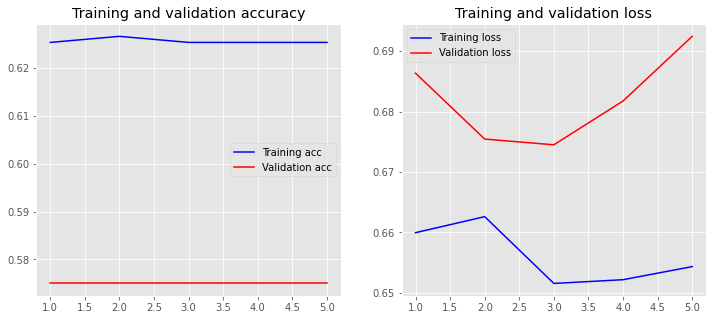

In [155]:
plt.style.use('ggplot')

def plot_history(model):
    acc = model.history['accuracy']
    val_acc = model.history['val_accuracy']
    loss = model.history['loss']
    val_loss = model.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

plot_history(model)